In [45]:
import os
import matplotlib
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

TRAIN_SIZE = 650
TEST_SIZE = 64
IMAGE_DIRECTORY='./data/'
NUM_IMAGES = 714
IMAGE_SIZE = 32
IMAGE_ARR_SIZE = 32 * 32 * 4
TYPE_ARRAY=np.array(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy',  
                    'Fighting', 'Fire', 'Ghost', 'Grass', 'Ground',  
                    'Ice','Normal','Poison','Psychic','Rock','Steel','Water'])\


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def load_images(image_dir):
    labels = []
    names = []
    image_index = 0
    
    
    # 714 because the Flying Pokemon were removed
    images = np.ndarray(shape=(714, IMAGE_ARR_SIZE))
                        
    
    # Loop through all the types directories
    for type in os.listdir(image_dir):
        type_images = os.listdir(image_dir + type + '/')
        
        # Loop through all the images of a type directory
        for image in type_images:
            image_file = os.path.join(image_dir, type, image)
            names.append(image)

            # reading the images as they are; no normalization, no color editing
            image_data = mpimg.imread(image_file) 
            #image_data = image_data.mean(axis=2).astype(np.float32)
            images[image_index, :] = image_data.flatten()
            image_index += 1
            labels.append(type)
        
    return (images, np.asarray(labels), np.asarray(names))


def plot_pokemon(data):
    plt.figure(figsize=(1,1))
    image = data.reshape(32, 32, 4)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    plt.show()

def plot_pokemons(instances, images_per_row=10, **options):
    size = IMAGE_SIZE
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size,4) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        #print (row, np.array(rimages).shape)    
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, **options)
    plt.axis("off")
    plt.show()
    
def get_pokemon_of_type(X, labels, type):
    poke_type = []
    for row in range(len(X)-1):
        if (labels[row]==type):
            poke_type.append(X[row])
    return np.asarray(poke_type)

def get_pokemon_type_index(type_name):
    for i in range(len(TYPE_ARRAY)):
        if TYPE_ARRAY[i] == type_name:
            return i;
    return 0

def get_labels_index(labels):
    labels_index = []
    for i in range(len(labels)):
        labels_index.append(get_pokemon_type_index(labels[i]))
    return labels_index  

In [46]:
height = 32
width = 32
channels = 4
n_inputs = height * width * channels

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 17

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 8 * 8])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [47]:
dataset, labels, names = load_images(IMAGE_DIRECTORY)
shuffle_index = np.random.permutation(NUM_IMAGES)
dataset, labels = dataset[shuffle_index], labels[shuffle_index]
labels_index = get_labels_index(labels)
X_train, labels_train, labels_index_train = dataset[:650], labels[:650], labels_index[:650]
X_test, labels_test = dataset[650:], labels_index[650:]

def get_next_batch(cursor, batchsize=50):
    if (cursor >= TRAIN_SIZE):
        cursor = 0
    X_batch, y_batch = X_train[cursor:cursor+batchsize], labels_index[cursor:cursor+batchsize]
    cursor = cursor + batchsize
    return cursor, X_batch, np.array(y_batch)

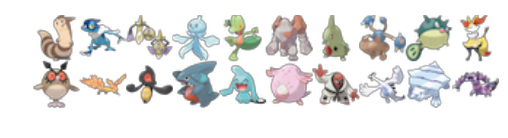

[11, 16, 15, 16, 8, 14, 14, 5, 16, 6, 11, 6, 7, 2, 13, 11, 5, 13, 10, 12]


In [51]:
plot_pokemons(X_test[:20])
print (labels_test[:20])

(0, 'Train accuracy:', 0.765625, 'Test accuracy:', 0.125)
(1, 'Train accuracy:', 0.90937501, 'Test accuracy:', 0.109375)
(2, 'Train accuracy:', 0.95937502, 'Test accuracy:', 0.109375)
(3, 'Train accuracy:', 0.97812498, 'Test accuracy:', 0.109375)
(4, 'Train accuracy:', 0.984375, 'Test accuracy:', 0.09375)
(5, 'Train accuracy:', 0.99374998, 'Test accuracy:', 0.140625)
(6, 'Train accuracy:', 1.0, 'Test accuracy:', 0.125)
(7, 'Train accuracy:', 1.0, 'Test accuracy:', 0.140625)
(8, 'Train accuracy:', 1.0, 'Test accuracy:', 0.140625)
(9, 'Train accuracy:', 1.0, 'Test accuracy:', 0.140625)


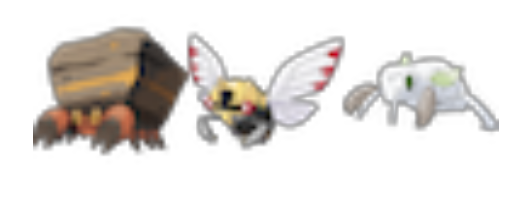

('Bug', 3, 'Accuracy:', 0.0)


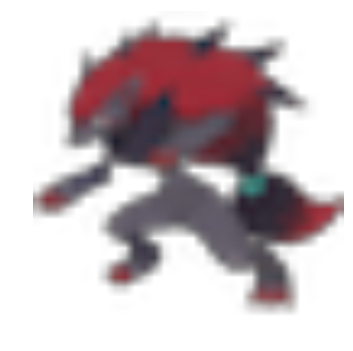

('Dark', 1, 'Accuracy:', 0.0)


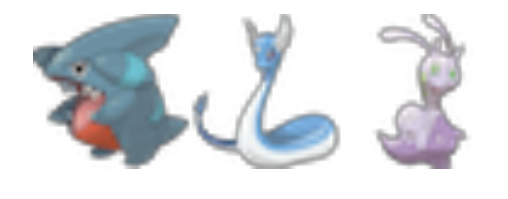

('Dragon', 3, 'Accuracy:', 0.0)


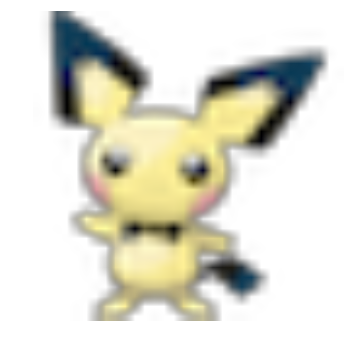

('Electric', 1, 'Accuracy:', 0.0)


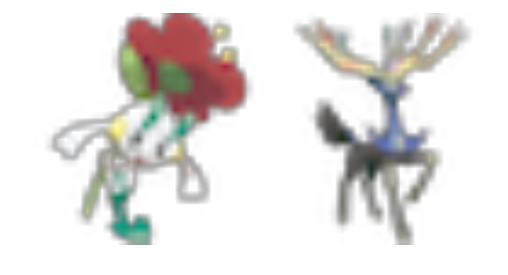

('Fairy', 2, 'Accuracy:', 0.0)


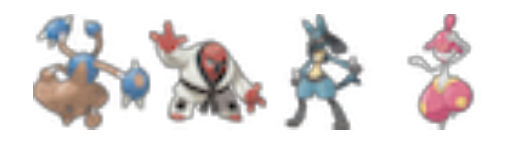

('Fighting', 4, 'Accuracy:', 0.0)


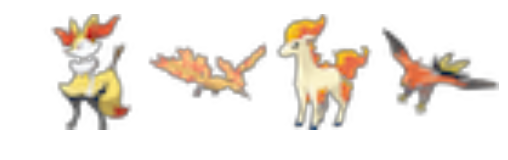

('Fire', 4, 'Accuracy:', 0.0)


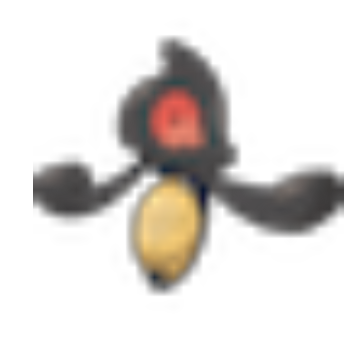

('Ghost', 1, 'Accuracy:', 1.0)


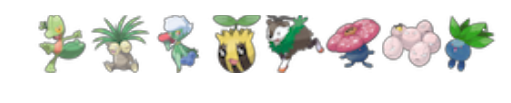

('Grass', 8, 'Accuracy:', 0.25)


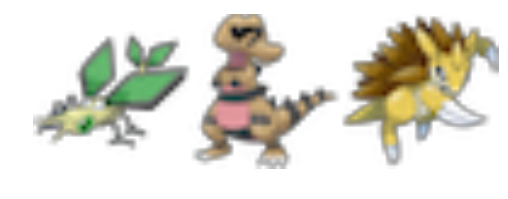

('Ground', 3, 'Accuracy:', 0.0)


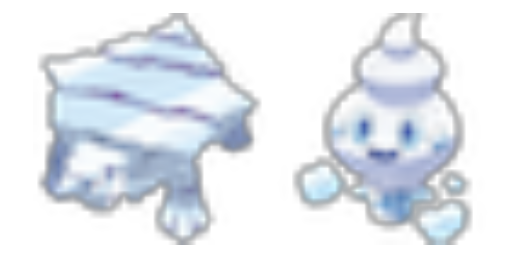

('Ice', 2, 'Accuracy:', 0.0)


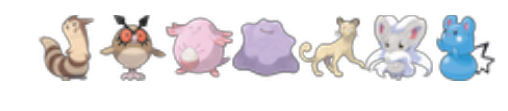

('Normal', 7, 'Accuracy:', 0.2857143)


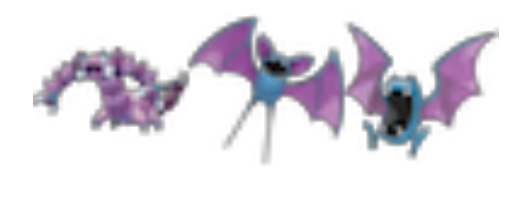

('Poison', 3, 'Accuracy:', 0.33333334)


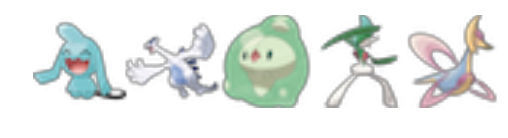

('Psychic', 5, 'Accuracy:', 0.0)


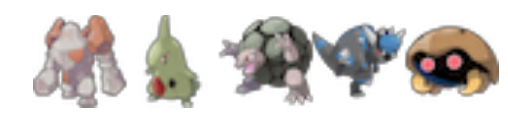

('Rock', 5, 'Accuracy:', 0.0)


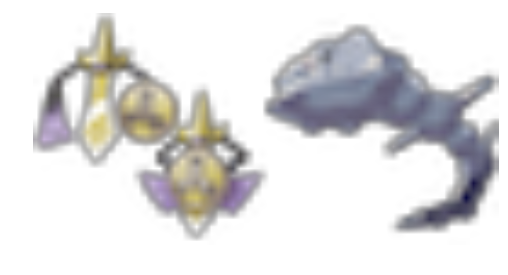

('Steel', 2, 'Accuracy:', 0.0)


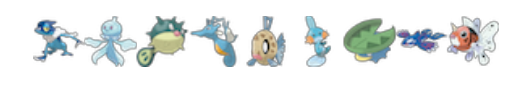

('Water', 9, 'Accuracy:', 0.33333334)


In [76]:
n_epochs = 10
batch_size = 10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        cursor = 0
        for iteration in range(TRAIN_SIZE // batch_size):
            cursor, X_batch, y_batch = get_next_batch(batch_size, cursor)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
       
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: labels_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")
        
    for i in range(len(TYPE_ARRAY)):
        poke = get_pokemon_of_type(dataset[650:], labels[650:], TYPE_ARRAY[i])
        plot_pokemons(poke)
        poke_labels = np.full(len(poke), i)
        poke_acc = accuracy.eval(feed_dict={X: poke, y: poke_labels})
        print (TYPE_ARRAY[i], len(poke), "Accuracy:", poke_acc)